<a href="https://colab.research.google.com/github/hamagami/anomaly-detection/blob/main/pycaret_anomaly_with_selfdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 自前データをつかった異常検知の例
ここでは，ご自身で用意されたデータを用いた異常検知を想定して，オープンデータ(csvファイル）をGoogleDrive上にダウンロードしたあと，そのファイルを読み込む手順で異常検知を行います。
データ入手は以下のサイトです
https://vincentarelbundock.github.io/Rdatasets/datasets.html

この中のDavisというデータセットをつかいます。データの詳しい説明は以下をみてください
https://vincentarelbundock.github.io/Rdatasets/doc/carData/Davis.html
この説明にある通り， 200行 and 5 列のデータです.
５つのカラムは，性別，測定された身長，測定された体重，自己申告された身長，自己申告された体重です。
GoogleDriveにcsvデータをダウンロードしたあと，pandas DataFrameをつかって読み込みます。手元のデータで試したい場合は，GoogleDriveにアップロードして同様の読み込みを行います。

--


knn, LOF, ABOD, HBOS, クラスタリング,部分空間法,PCA, MCD,Oneclass SVM, Isolation forest

pycaretをインストールします。
1分ほどかかります。他のモジュールとの依存関係について，いくつかエラーが表示されますが，今回の範囲では問題ありません，

In [1]:
!pip -q install pycaret

実行に必要なモジュールをいくつか読み込みます

In [2]:
from pycaret.anomaly import *         #  PyCaretの異常検知関連のモジュールを読みこみます

import pandas as pd                   # pandasとは，表形式のデータを扱う便利なモジュールです　PyCaretの入出力はpandasのDataFrameと呼ぶ表形式のデータ型をつかいます
import matplotlib.pyplot as plt       # グラフを表示するモジュールを読みこみます

# pandasバージョン依存
pd.DataFrame.iteritems = pd.DataFrame.items

## 準備ができました。ここからPyCaretを実際に動かしていきます

### データの読み込み

データをダウンロードしたファイルは，Googledriveにいったん保存されます。
そのファイルを pandas DataFrameとして読み込みます。その結果は datasetという変数にはいります。最初の５行だけ表示させています。
カラム名の　repwt, repht はそれぞれ自己申告の体重と身長です

In [3]:
!wget "vincentarelbundock.github.io/Rdatasets/csv/carData/Davis.csv"
dataset = pd.read_csv("Davis.csv", index_col=0) #最初の列は行番号なので，それをindexにするように指定している
dataset.head()

--2024-06-15 02:36:55--  http://vincentarelbundock.github.io/Rdatasets/csv/carData/Davis.csv
Resolving vincentarelbundock.github.io (vincentarelbundock.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to vincentarelbundock.github.io (vincentarelbundock.github.io)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://vincentarelbundock.github.io/Rdatasets/csv/carData/Davis.csv [following]
--2024-06-15 02:36:55--  https://vincentarelbundock.github.io/Rdatasets/csv/carData/Davis.csv
Connecting to vincentarelbundock.github.io (vincentarelbundock.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3855 (3.8K) [text/csv]
Saving to: ‘Davis.csv.2’

Davis.csv.2         100%[===================>]   3.76K  --.-KB/s    in 0s      

2024-06-15 02:36:55 (46.4 MB/s) - ‘Davis.csv.2’ saved [3855/3855]



,sex,weight,height,repwt,repht
rownames,,,,,
1,M,77,182,77.0,180.0
2,F,58,161,51.0,159.0
3,F,53,161,54.0,158.0
4,M,68,177,70.0,175.0
5,F,59,157,59.0,155.0


データのサイズを確認しておきます。200行5列であることがわかります

In [4]:
dataset.shape  # 1000行10列

(200, 5)

本当はここで，各属性(カラム）の欠損を確認すべきところですが，今回は省略します。実際にはこのデータに欠損はありません。次に，各属性ごとのデータの分布をみておきます。分布を確認しなくてもこれ以降の処理は可能ですが，ある程度分布を押さえておくとトラブルシューティングの際に役立ちます。グラフを書くと，１～４程度のピークを持つ様々な分布を含んでいることがわかります。この程度のデータであっても，外れを直観的にみつけることは難しそうです。

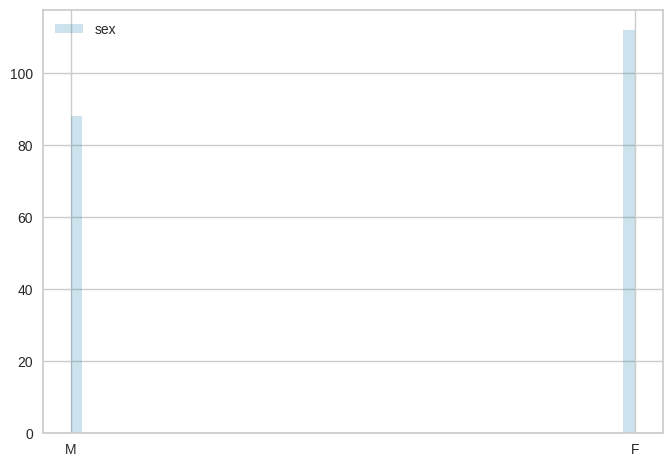

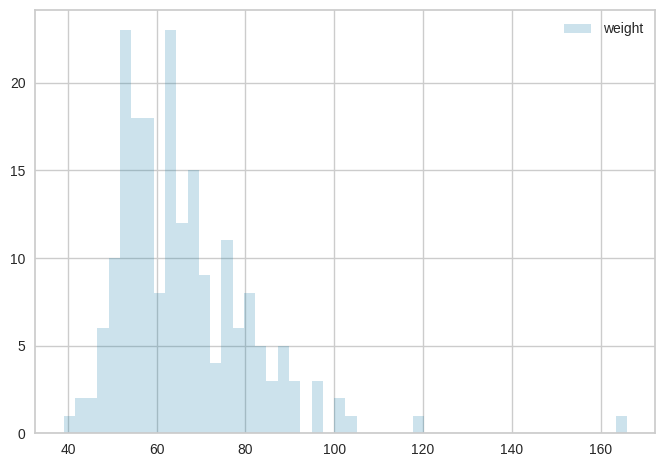

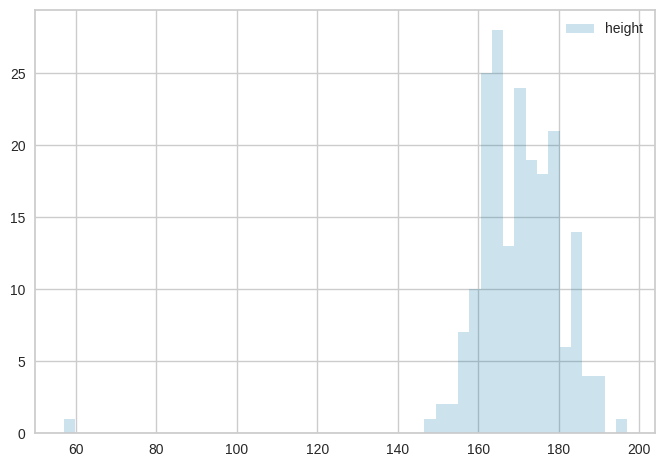

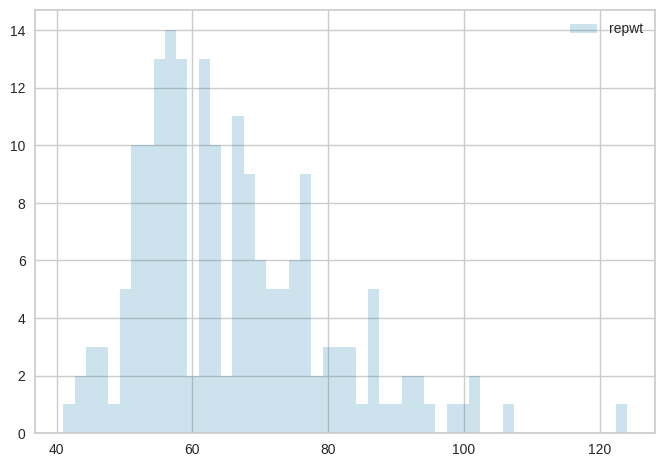

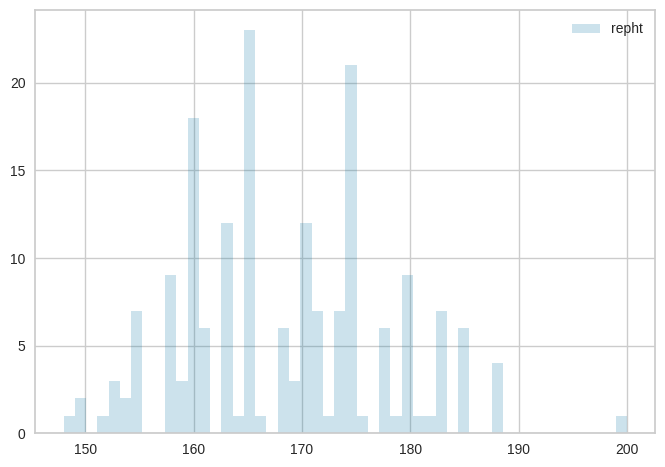

In [5]:
#以下の処理は理解できなくても問題ありません。各カラムごとに半透明のヒストグラムを重ねて書いています
for item, data in dataset.iteritems(): #１列ずつ取り出す
  plt.hist(data,bins=50,label=item,alpha=0.2)
  plt.legend()
  plt.show()

男性，女性別に，体重，身長の分布を確認してみます。明らかな異常値（入力間違い？）があることがわかります。本来はこのような入力エラーはクレンジングで取り除くべきところですが，ここでは特に処理をせずに進めていきます

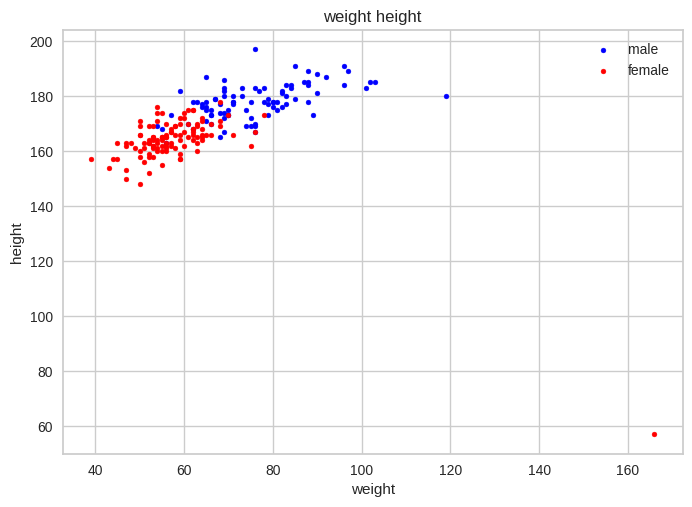

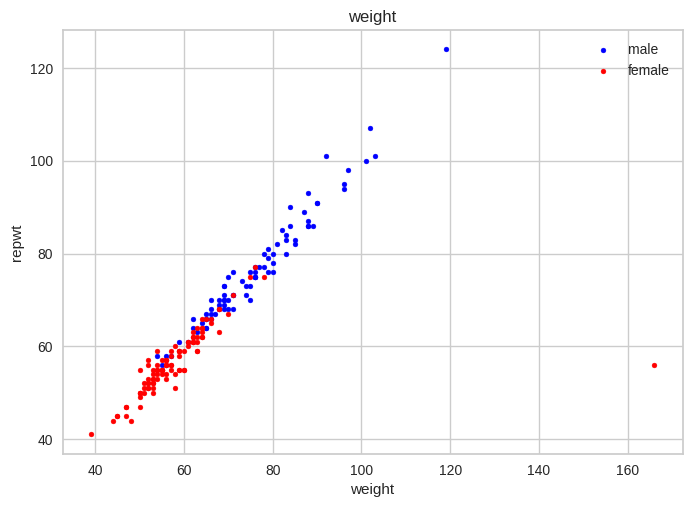

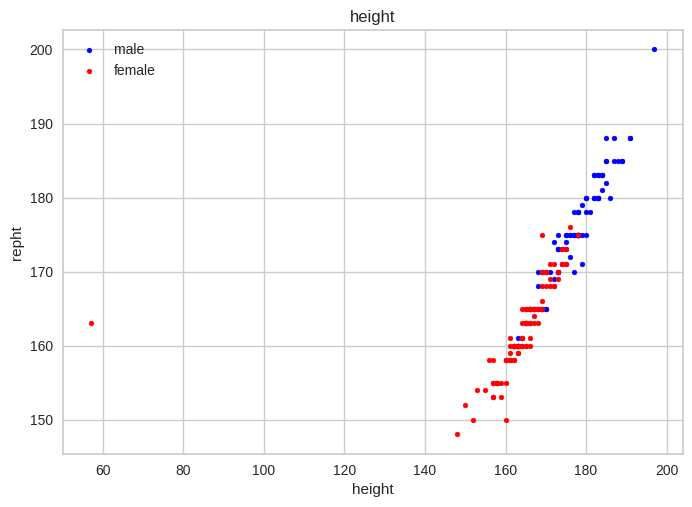

In [6]:
mdf= dataset[dataset["sex"]=="M"]#男性データのみ
fdf= dataset[dataset["sex"]=="F"]#女性データのみ

plt.scatter(mdf["weight"],mdf["height"],color="blue",marker=".")
plt.scatter(fdf["weight"],fdf["height"],color="red",marker=".")
plt.xlabel("weight")
plt.ylabel("height")
plt.title("weight height")
plt.legend(["male","female"])
plt.show()



plt.scatter(mdf["weight"],mdf["repwt"],color="blue",marker=".")
plt.scatter(fdf["weight"],fdf["repwt"],color="red",marker=".")
plt.xlabel("weight")
plt.ylabel("repwt")
plt.title("weight")
plt.legend(["male","female"])
plt.show()

plt.scatter(mdf["height"],mdf["repht"],color="blue",marker=".")
plt.scatter(fdf["height"],fdf["repht"],color="red",marker=".")
plt.xlabel("height")
plt.ylabel("repht")
plt.title("height")
plt.legend(["male","female"])
plt.show()

### セットアップ

PyCaretでは，面倒なデータの前処理を自動化するしくみがあります。これをsetupといいます。setupには，前処理のための様々なオプションがあります。ここでは，元のデータが0～1に規格化されているため，改めて標準化（各属性の分布を平均0,分散1にしまｓ）を行わないようにしています。予めデータの分布を確認して，必要に応じて標準化，正規化をするようにしてください。またデータ全体に占める異常の割合を3%と設定しています。このパラメータはあとでまた再検討します。setupを行うと，データに関する情報・操作内容の一覧が出力されます。
Davis は欠損値がありますがそれも自動で補間してくれます。

In [7]:
anoexe = setup(dataset,normalize=False,outliers_threshold=0.05) #データの範囲はほぼ0～1に収まっているので特段前処理を行わない設定にしている

,Description,Value
0,Session id,5975
1,Original data shape,"(200, 5)"
2,Transformed data shape,"(200, 5)"
3,Numeric features,4
4,Categorical features,1
5,Rows with missing values,9.5%
6,Preprocess,True
7,Imputation type,simple
8,Numeric imputation,mean
9,Categorical imputation,mode


準備が整ったので，異常検知をためしてみます。
どのような異常検知アルゴリズムが使えるかは，models()で確認できます。

In [8]:
models()

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pycaret.internal.patches.pyod.CBLOFForceToDouble
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


**以下ではこれらのアルゴリズムを実行します。**

knn, LOF, ABOD, HBOS, クラスタリング,部分空間法,PCA, MCD,Oneclass SVM, Isolation forest

これらのアルゴリズムを適用すると，AnomalyScoreという異常値が得られます。この異常値をもとに適切な閾値で正常・外れを判定することができます。閾値は自分で設定「してもいいですが，ここではPyCaretが自動的に設定した値をもとに外れ判定をした結果 Anomaly をそのまま使って，外れのサンプルを赤のマーカーで表示しています。



---



---

## **knn**


knnの学習モデルをつくります

Create a learning model for knn.

In [9]:
knn_model = create_model('knn')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

knnの学習を行います


learning knn model

In [10]:
knn_results = assign_model(knn_model)

得られた結果を簡易的にグラフにします。横軸にデータ番号(0～999) 縦軸が異常度です。自動で設定された閾値に基づいて異常判定を行った結果を赤色の帯で表しています。

The obtained results are simply graphed. The horizontal axis is the data number (0 to 999) and the vertical axis is the abnormality level. The results of the abnormality judgment based on the automatically set threshold values are shown in light blue bands.

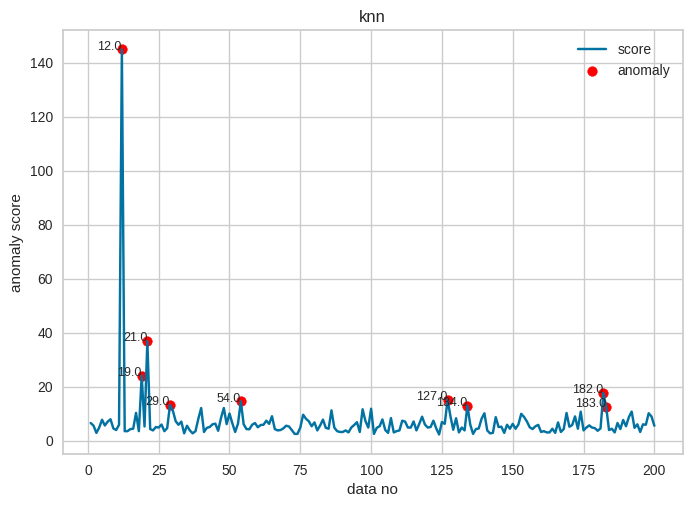

In [11]:
threshold=1
plt.plot(knn_results["Anomaly_Score"],label="score")
above_threshold = knn_results["Anomaly"] >= threshold
anomalydata =knn_results["Anomaly_Score"][above_threshold]
plt.scatter(anomalydata.index,anomalydata,label="anomaly",marker="o",color="red" )

for i in range(len(anomalydata)):
    plt.text(anomalydata.index[i], anomalydata.iloc[i], f'{anomalydata.index[i]:.1f}', fontsize=9, ha='right')

plt.title("knn")
plt.xlabel("data no")
plt.ylabel("anomaly score")
plt.legend()
plt.show()

異常度の分布を確認しおきます。水色が正常判定されたAnomaly_Score，赤が異常判定されたAnomaly_Scoreです。setupで全体の集合の5%が外れているという仮定で閾値がされているため，上位50までの外れが外れ値にしています。
このヒストグラムをみて，分布に基づく閾値（ネイマンピアソン決定則）を適用してもいいです。

The distribution of abnormality is shown below. Light blue is the normalized Anomaly_Score and orange is the abnormalized Anomaly_Score.
You can look at this histogram and apply a threshold based on the distribution (Neyman-Pearson decision rule).

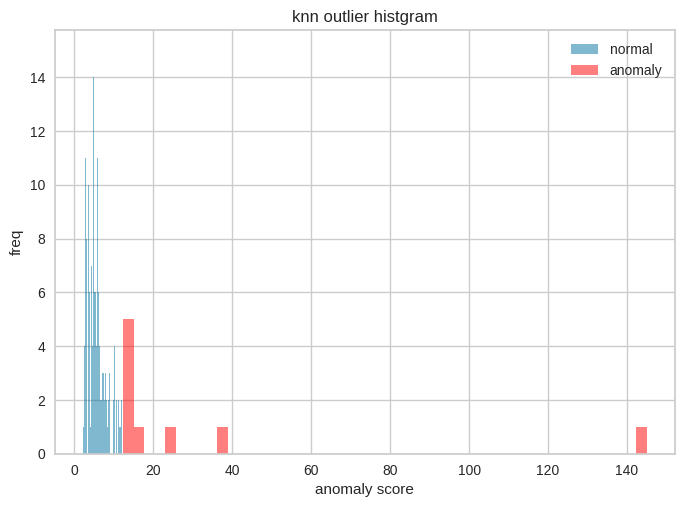

In [12]:
plt.hist(knn_results[knn_results["Anomaly"]==0]["Anomaly_Score"],bins=50,alpha=0.5,label="normal")
plt.hist(knn_results[knn_results["Anomaly"]==1]["Anomaly_Score"],bins=50,alpha=0.5,color="red",label="anomaly")
plt.title("knn outlier histgram")
plt.xlabel("anomaly score")
plt.ylabel("freq")
plt.legend()
plt.show()



---
## **局所外れ因子　Local Outlier Factor: LOF**



knnと同様にモデルの生成，学習を行います

In [13]:
lof_model = create_model('lof')
lof_results = assign_model(lof_model)

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

異常度と判定結果を描画します。
異常度の値の範囲がknnとは異なりますが，ほぼ同じ個所で異常が検出できていることがわかります

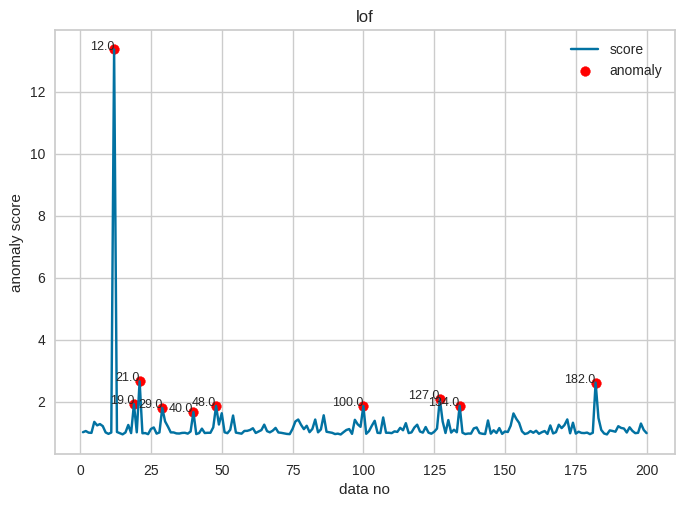

In [14]:
plt.plot(lof_results["Anomaly_Score"],label="score")
above_threshold = lof_results["Anomaly"] >= threshold
anomalydata =lof_results["Anomaly_Score"][above_threshold]
plt.scatter(anomalydata.index,anomalydata,label="anomaly",marker="o",color="red" )

for i in range(len(anomalydata)):
    plt.text(anomalydata.index[i], anomalydata.iloc[i], f'{anomalydata.index[i]:.1f}', fontsize=9, ha='right')


plt.title("lof")
plt.xlabel("data no")
plt.ylabel("anomaly score")
plt.legend()
plt.show()

異常度のヒストグラムをとると，knnに比べて正常データの凝集がより強くなっており，異常検知が容易になっていることがわかります。こちらもこの分布をもとに統計的な意味をもった閾値を再設定をすると，より厳密な異常検知となります。

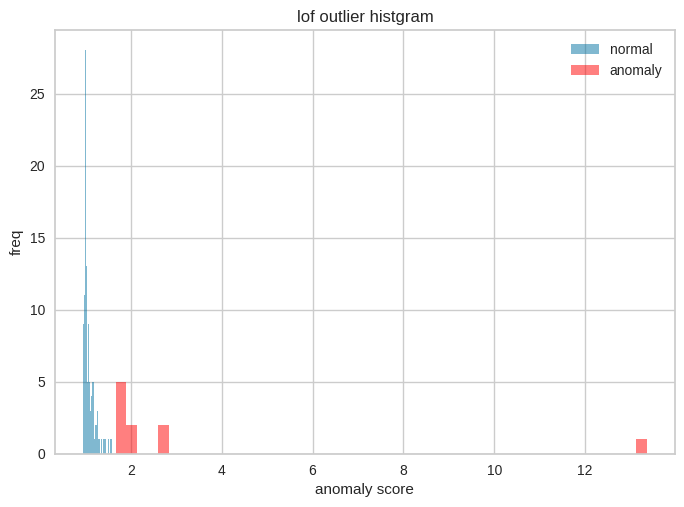

In [15]:
plt.hist(lof_results[lof_results["Anomaly"]==0]["Anomaly_Score"],bins=50,alpha=0.5,label="normal")
plt.hist(lof_results[lof_results["Anomaly"]==1]["Anomaly_Score"],bins=50,alpha=0.5,color="red",label="anomaly")
plt.title("lof outlier histgram")
plt.xlabel("anomaly score")
plt.ylabel("freq")
plt.legend()
plt.show()

## **ABOD**

他のアルゴリズムについても同様にみていきます

In [16]:
abod_model = create_model('abod')
abod_results = assign_model(abod_model)

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

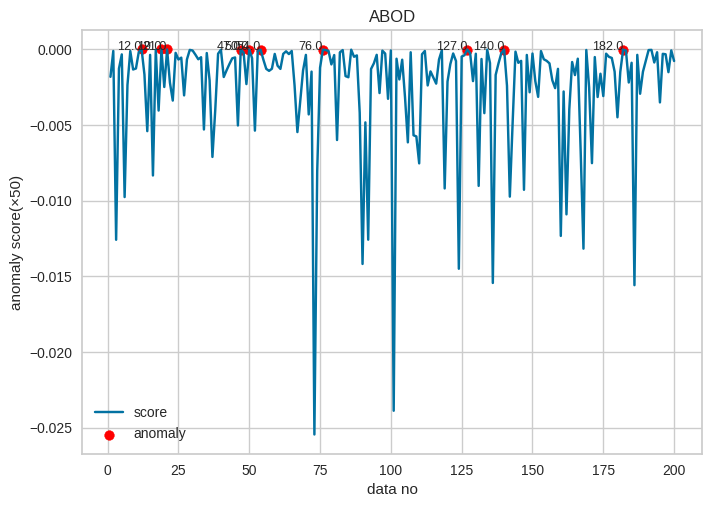

In [17]:
plt.plot(abod_results["Anomaly_Score"],label="score")
above_threshold = abod_results["Anomaly"] >= threshold
anomalydata =abod_results["Anomaly_Score"][above_threshold]
plt.scatter(anomalydata.index,anomalydata,label="anomaly",marker="o",color="red" )

for i in range(len(anomalydata)):
    plt.text(anomalydata.index[i], anomalydata.iloc[i], f'{anomalydata.index[i]:.1f}', fontsize=9, ha='right')


plt.title("ABOD")
plt.xlabel("data no")
plt.ylabel("anomaly score(×50)")
plt.legend()
plt.show()

異常度の分布でみると，異常データは0付近の大変狭い領域内に凝集しているが，すぐそばに正常データも多くあり，正常と異常の境界が重なっていることがわかる。正常と異常の分離はできているが，このデータは10次元のため高次元に強いABODのメリットがあまり生かされていないと考えられる

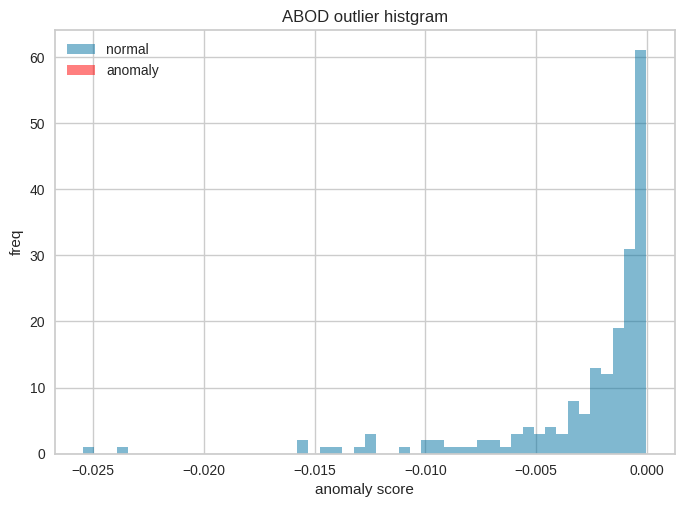

In [18]:
plt.hist(abod_results[abod_results["Anomaly"]==0]["Anomaly_Score"],bins=50,alpha=0.5,label="normal")
plt.hist(abod_results[abod_results["Anomaly"]==1]["Anomaly_Score"],bins=1,alpha=0.5,color="red",label="anomaly")
plt.title("ABOD outlier histgram")
plt.xlabel("anomaly score")
plt.ylabel("freq")
plt.legend()
plt.show()



---

# **HBOS**

In [19]:
hbos_model = create_model('histogram')
hbos_results = assign_model(hbos_model)

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

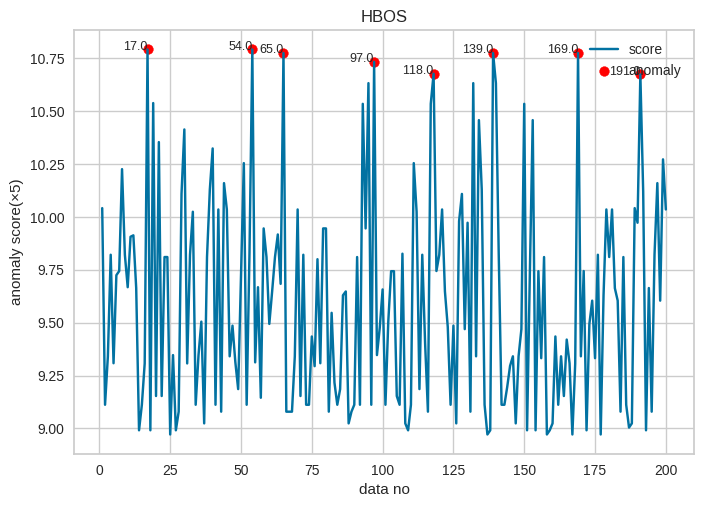

In [20]:
plt.plot(hbos_results["Anomaly_Score"],label="score")
above_threshold = hbos_results["Anomaly"] >= threshold
anomalydata =hbos_results["Anomaly_Score"][above_threshold]
plt.scatter(anomalydata.index,anomalydata,label="anomaly",marker="o",color="red" )

for i in range(len(anomalydata)):
    plt.text(anomalydata.index[i], anomalydata.iloc[i], f'{anomalydata.index[i]:.1f}', fontsize=9, ha='right')


plt.title("HBOS")
plt.xlabel("data no")
plt.ylabel("anomaly score(×5)")
plt.legend()
plt.show()

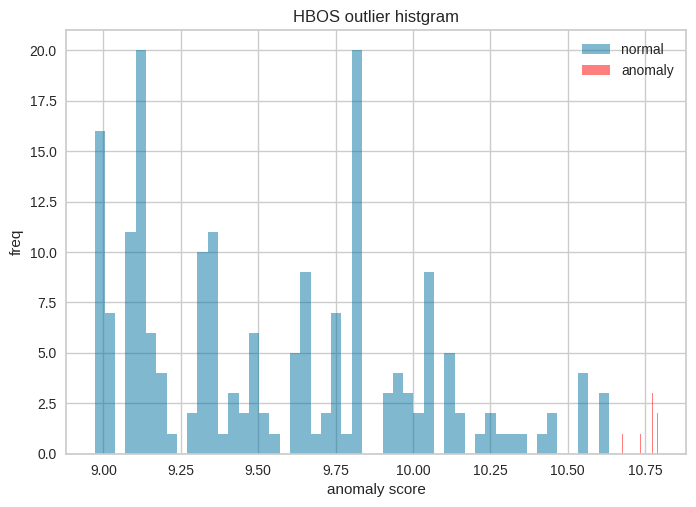

In [21]:
plt.hist(hbos_results[hbos_results["Anomaly"]==0]["Anomaly_Score"],bins=50,alpha=0.5,label="normal")
plt.hist(hbos_results[hbos_results["Anomaly"]==1]["Anomaly_Score"],bins=50,alpha=0.5,color="red",label="anomaly")
plt.title("HBOS outlier histgram")
plt.xlabel("anomaly score")
plt.ylabel("freq")
plt.legend()
plt.show()



---

# **クラスタリング**

In [22]:
clust_model = create_model('cluster')
clust_results = assign_model(clust_model)

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

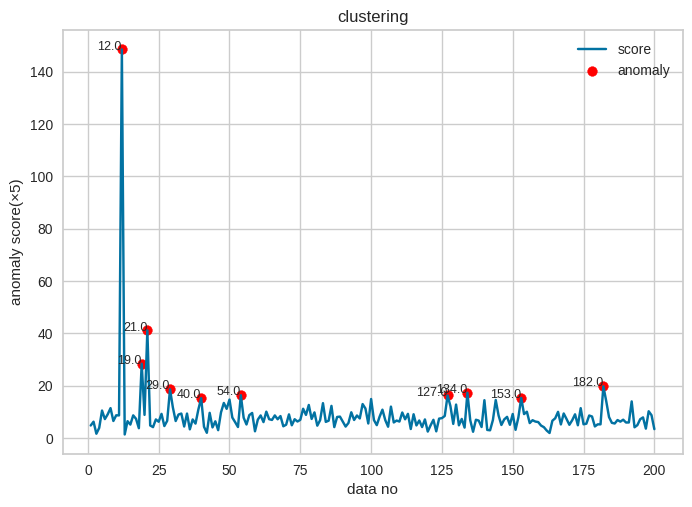

In [23]:
plt.plot(clust_results["Anomaly_Score"],label="score")
above_threshold = clust_results["Anomaly"] >= threshold
anomalydata =clust_results["Anomaly_Score"][above_threshold]
plt.scatter(anomalydata.index,anomalydata,label="anomaly",marker="o",color="red" )

for i in range(len(anomalydata)):
    plt.text(anomalydata.index[i], anomalydata.iloc[i], f'{anomalydata.index[i]:.1f}', fontsize=9, ha='right')


plt.title("clustering")
plt.xlabel("data no")
plt.ylabel("anomaly score(×5)")
plt.legend()
plt.show()

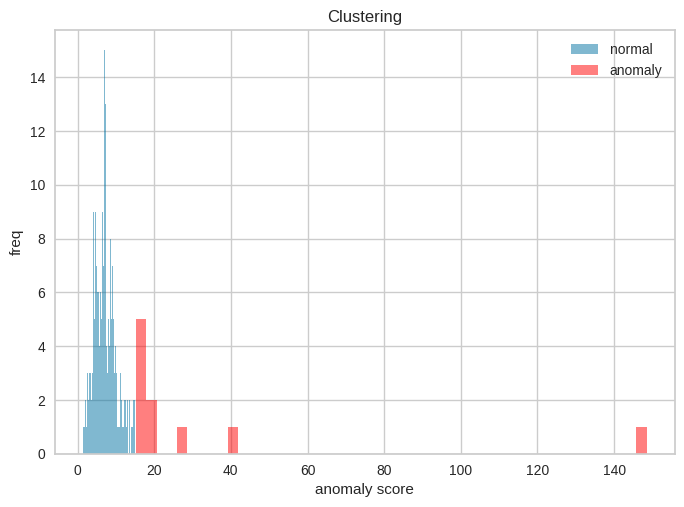

In [24]:
plt.hist(clust_results[clust_results["Anomaly"]==0]["Anomaly_Score"],bins=50,alpha=0.5,label="normal")
plt.hist(clust_results[clust_results["Anomaly"]==1]["Anomaly_Score"],bins=50,alpha=0.5,color="red",label="anomaly")
plt.title("Clustering")
plt.xlabel("anomaly score")
plt.ylabel("freq")
plt.legend()
plt.show()



---
# **部分空間法**


In [25]:
sod_model = create_model('sod')
sod_results = assign_model(sod_model)

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

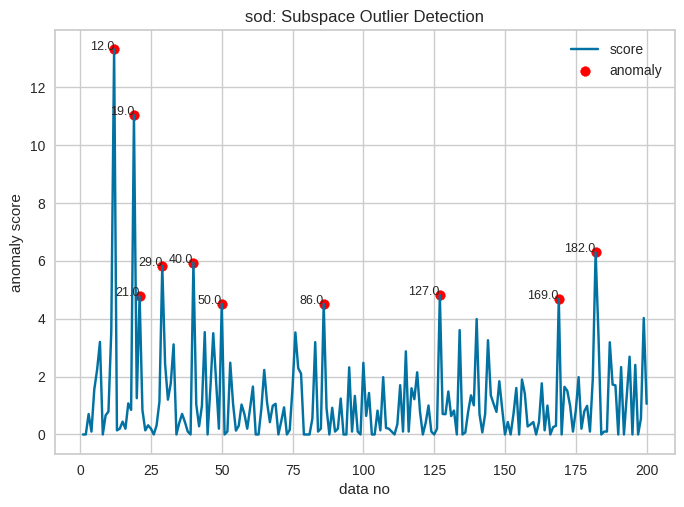

In [26]:
plt.plot(sod_results["Anomaly_Score"],label="score")
above_threshold = sod_results["Anomaly"] >= threshold
anomalydata =sod_results["Anomaly_Score"][above_threshold]
plt.scatter(anomalydata.index,anomalydata,label="anomaly",marker="o",color="red" )

for i in range(len(anomalydata)):
    plt.text(anomalydata.index[i], anomalydata.iloc[i], f'{anomalydata.index[i]:.1f}', fontsize=9, ha='right')

plt.title("sod: Subspace Outlier Detection")
plt.xlabel("data no")
plt.ylabel("anomaly score")
plt.legend()
plt.show()

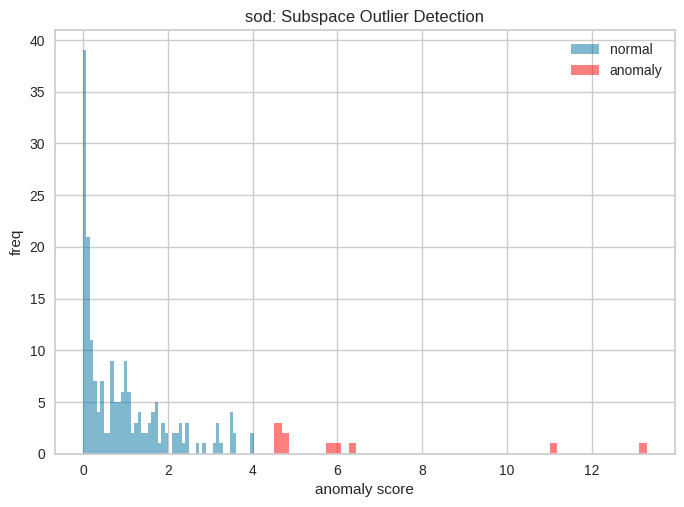

In [27]:
plt.hist(sod_results[sod_results["Anomaly"]==0]["Anomaly_Score"],bins=50,alpha=0.5,label="normal")
plt.hist(sod_results[sod_results["Anomaly"]==1]["Anomaly_Score"],bins=50,alpha=0.5,color="red",label="anomaly")
plt.title("sod: Subspace Outlier Detection")
plt.xlabel("anomaly score")
plt.ylabel("freq")
plt.legend()
plt.show()



---
# **PCA, MCD**


In [28]:
pca_model = create_model('pca')
pca_results = assign_model(pca_model)

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

PCAは正常・異常関係なく直交空間をつくっているため，異常値の影響をうけてしまいます

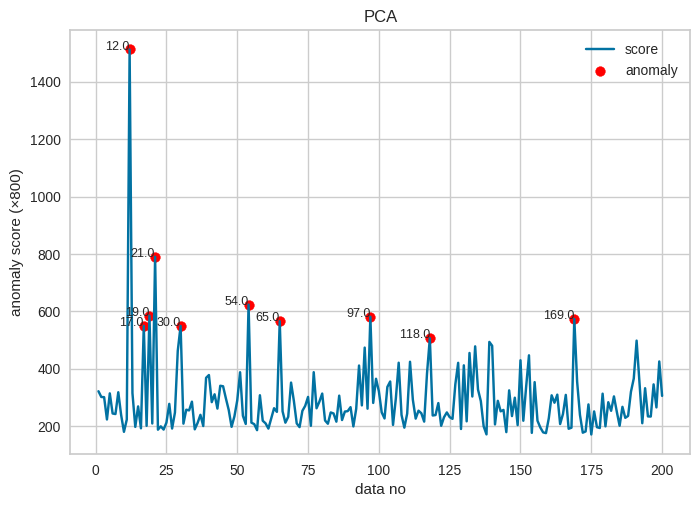

In [29]:
plt.plot(pca_results["Anomaly_Score"],label="score")
above_threshold = pca_results["Anomaly"] >= threshold
anomalydata =pca_results["Anomaly_Score"][above_threshold]
plt.scatter(anomalydata.index,anomalydata,label="anomaly",marker="o",color="red" )

for i in range(len(anomalydata)):
    plt.text(anomalydata.index[i], anomalydata.iloc[i], f'{anomalydata.index[i]:.1f}', fontsize=9, ha='right')


plt.title("PCA")
plt.xlabel("data no")
plt.ylabel("anomaly score (×800)")
plt.legend()
plt.show()

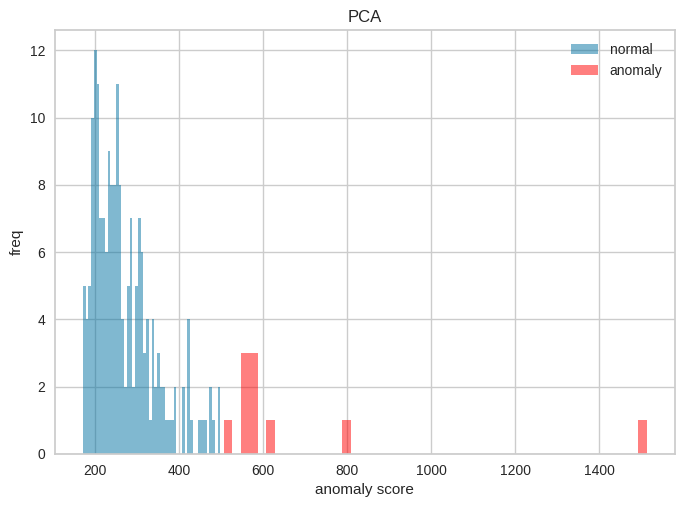

In [30]:
plt.hist(pca_results[pca_results["Anomaly"]==0]["Anomaly_Score"],bins=50,alpha=0.5,label="normal")
plt.hist(pca_results[pca_results["Anomaly"]==1]["Anomaly_Score"],bins=50,alpha=0.5,color="red",label="anomaly")
plt.title("PCA")
plt.xlabel("anomaly score")
plt.ylabel("freq")
plt.legend()
plt.show()

In [31]:
mcd_model = create_model('mcd')
mcd_results = assign_model(mcd_model)


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

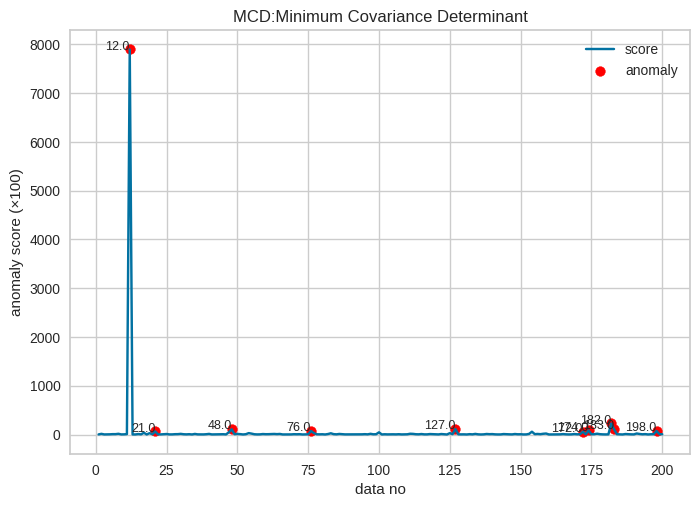

In [32]:
plt.plot(mcd_results["Anomaly_Score"],label="score")
above_threshold = mcd_results["Anomaly"] >= threshold
anomalydata =mcd_results["Anomaly_Score"][above_threshold]
plt.scatter(anomalydata.index,anomalydata,label="anomaly",marker="o",color="red" )

for i in range(len(anomalydata)):
    plt.text(anomalydata.index[i], anomalydata.iloc[i], f'{anomalydata.index[i]:.1f}', fontsize=9, ha='right')

plt.title("MCD:Minimum Covariance Determinant")
plt.xlabel("data no")
plt.ylabel("anomaly score (×100)")
plt.legend()
plt.show()

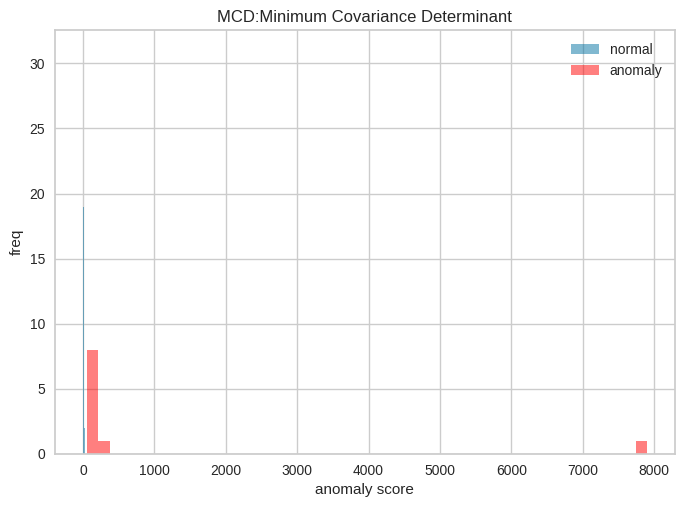

In [33]:
plt.hist(mcd_results[mcd_results["Anomaly"]==0]["Anomaly_Score"],bins=50,alpha=0.5,label="normal")
plt.hist(mcd_results[mcd_results["Anomaly"]==1]["Anomaly_Score"],bins=50,alpha=0.5,color="red",label="anomaly")
plt.title("MCD:Minimum Covariance Determinant")
plt.xlabel("anomaly score")
plt.ylabel("freq")
plt.legend()
plt.show()



---
# **one class SVM**


In [34]:
svm_model = create_model('svm', kernel="rbf", fraction=0.01)
svm_results = assign_model(svm_model)


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

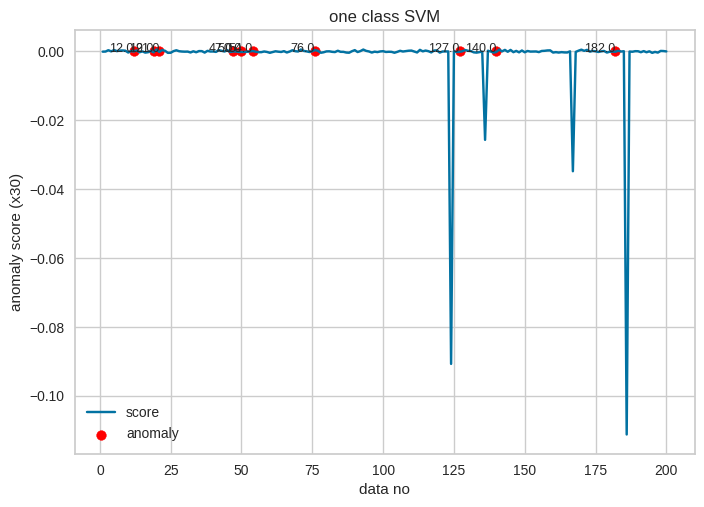

In [35]:
plt.plot(svm_results["Anomaly_Score"],label="score")
above_threshold = abod_results["Anomaly"] >= threshold
anomalydata =abod_results["Anomaly_Score"][above_threshold]
plt.scatter(anomalydata.index,anomalydata,label="anomaly",marker="o",color="red" )

for i in range(len(anomalydata)):
    plt.text(anomalydata.index[i], anomalydata.iloc[i], f'{anomalydata.index[i]:.1f}', fontsize=9, ha='right')


plt.title("one class SVM")
plt.xlabel("data no")
plt.ylabel("anomaly score (x30)")
plt.legend()
plt.show()



---

# **isolation forest**

In [36]:
if_model = create_model('iforest', fraction=0.01)
if_results = assign_model(if_model)


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

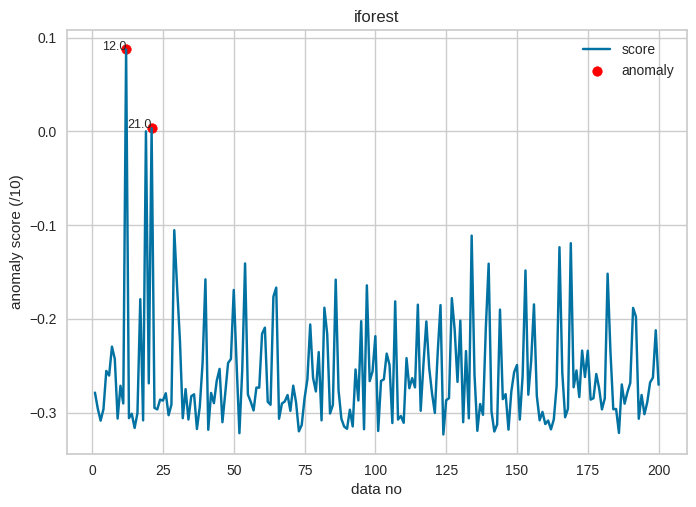

In [37]:
plt.plot(if_results["Anomaly_Score"],label="score")
above_threshold = if_results["Anomaly"] >= threshold
anomalydata =if_results["Anomaly_Score"][above_threshold]
plt.scatter(anomalydata.index,anomalydata,label="anomaly",marker="o",color="red" )

for i in range(len(anomalydata)):
    plt.text(anomalydata.index[i], anomalydata.iloc[i], f'{anomalydata.index[i]:.1f}', fontsize=9, ha='right')


plt.title("iforest")
plt.xlabel("data no")
plt.ylabel("anomaly score (/10)")
plt.legend()
plt.show()